In [172]:
# importing python packages
import logging
import pandas as pd
import numpy as np
import scipy.stats as stats
import pathlib
import matplotlib.pyplot as plt
import time
import os
import warnings
import base64

from pathlib import Path
from sklearn.ensemble import GradientBoostingClassifier

from azdslib.workflow import DSFlow
from azdslib.ml import CategoricalTransformer, NumericTransformer, FuncTransformer
from azdslib.util import prepare_data_frame, check_data_frame, MLServerClient

# Trick to update proxy settings. Should not be needed once migration is done.
no_prox = "localhost,127.0.0.1,gda.allianz,dsp.allianz"
os.environ['no_proxy'] = no_prox
os.environ['NO_PROXY'] = no_prox

pd.options.display.max_columns = 50
logging.basicConfig(level=logging.INFO)
_logger = logging.getLogger(__name__)

# Data paths
train_data_root = pathlib.Path('data/train/')
test_data_root = pathlib.Path('data/test/')

ch_o = pd.read_csv(train_data_root / "cal_housing_owners.csv")
ch_p = pd.read_csv(train_data_root / "cal_housing_properties.csv")
ch_op = pd.read_csv(train_data_root / "cal_housing_owner_property.csv")

In [173]:
# define a function to convert the latitude and longitude to a single geohash
def geoencode(latitude, longitude, precision=12):
    """
    Encode a position given in float arguments latitude, longitude to
    a geohash which will have the character count precision.
    """
    __base32 = '0123456789bcdefghjkmnpqrstuvwxyz'
    lat_interval = (-90.0, 90.0)
    lon_interval = (-180.0, 180.0)
    geohash = []
    bits = [16, 8, 4, 2, 1]
    bit = 0
    ch = 0
    even = True
    while len(geohash) < precision:
        if even:
            mid = (lon_interval[0] + lon_interval[1]) / 2
            if longitude > mid:
                ch |= bits[bit]
                lon_interval = (mid, lon_interval[1])
            else:
                lon_interval = (lon_interval[0], mid)
        else:
            mid = (lat_interval[0] + lat_interval[1]) / 2
            if latitude > mid:
                ch |= bits[bit]
                lat_interval = (mid, lat_interval[1])
            else:
                lat_interval = (lat_interval[0], mid)
        even = not even
        if bit < 4:
            bit += 1
        else:
            geohash += __base32[ch]
            bit = 0
            ch = 0
    return ''.join(geohash)

In [197]:
# Clean our input data and convert our geographical positioning data to an equivalent geohash
full_df = pd.merge(ch_p, ch_op, how = 'left', on = ['property_id'])
full_df = full_df[~full_df['median_house_value_cat'].isnull()]
full_df = full_df[full_df['total_rooms'] != 'unknown']
full_df['total_rooms'] = pd.to_numeric(full_df['total_rooms'])
full_df['paid_price'].fillna(full_df[~full_df['paid_price'].isnull()]['paid_price'].median(), inplace = True)
full_df['geohash'] = full_df.apply(lambda row: geoencode(row['latitude'], row['longitude'], 2), axis = 1)
full_df = full_df[[
    'geohash',
    'ocean_proximity',
    'paid_price',
    'total_rooms',
    'median_house_value_cat'
]]
full_df = pd.concat([full_df, pd.get_dummies(full_df['ocean_proximity']), pd.get_dummies(full_df['geohash'])], axis = 1)
full_df.corr()

,paid_price,total_rooms,median_house_value_cat,<1H OCEAN,INLAND,ISLAND,NEAR BAY,NEAR OCEAN,9m,9n,9p,9q,9r
paid_price,1.000000,0.114840,0.679851,0.224150,-0.430014,0.014618,0.150234,0.125283,0.031557,-0.005011,-0.070174,0.048149,-0.147937
total_rooms,0.114840,1.000000,0.127394,-0.005685,0.033447,-0.007047,-0.021576,-0.017662,0.055773,-0.004530,-0.025005,-0.033249,-0.029627
median_house_value_cat,0.679851,0.127394,1.000000,0.289020,-0.479782,0.013662,0.130769,0.116680,0.020558,-0.007894,-0.082693,0.064767,-0.156854
<1H OCEAN,0.224150,-0.005685,0.289020,1.000000,-0.608650,-0.012134,-0.312712,-0.341551,0.031504,0.008888,-0.022977,0.032079,-0.134865
INLAND,-0.430014,0.033447,-0.479782,-0.608650,1.000000,-0.009370,-0.241491,-0.263762,-0.186920,-0.005410,-0.056668,0.090337,0.225317
ISLAND,0.014618,-0.007047,0.013662,-0.012134,-0.009370,1.000000,-0.004814,-0.005258,0.034509,-0.000108,-0.001130,-0.030508,-0.002176
NEAR BAY,0.150234,-0.021576,0.130769,-0.312712,-0.241491,-0.004814,1.000000,-0.135515,-0.139506,-0.002779,-0.029115,0.157803,-0.056073
NEAR OCEAN,0.125283,-0.017662,0.116680,-0.341551,-0.263762,-0.005258,-0.135515,1.000000,0.342496,-0.003036,0.140174,-0.319554,-0.061244
9m,0.031557,0.055773,0.020558,0.031504,-0.186920,0.034509,-0.139506,0.342496,1.000000,-0.003125,-0.032737,-0.884055,-0.063048
9n,-0.005011,-0.004530,-0.007894,0.008888,-0.005410,-0.000108,-0.002779,-0.003036,-0.003125,1.000000,-0.000652,-0.017613,-0.001256


# Explore Data

Free data exploration. Your task to finalize before lunch is to have chosen 5 to 6 fearures to use for modeling, or an alternative strategy to select those. 
While you explore data and prepare them write a function get_data. Input is free (e.g. path to files), output must be 
[features, target]

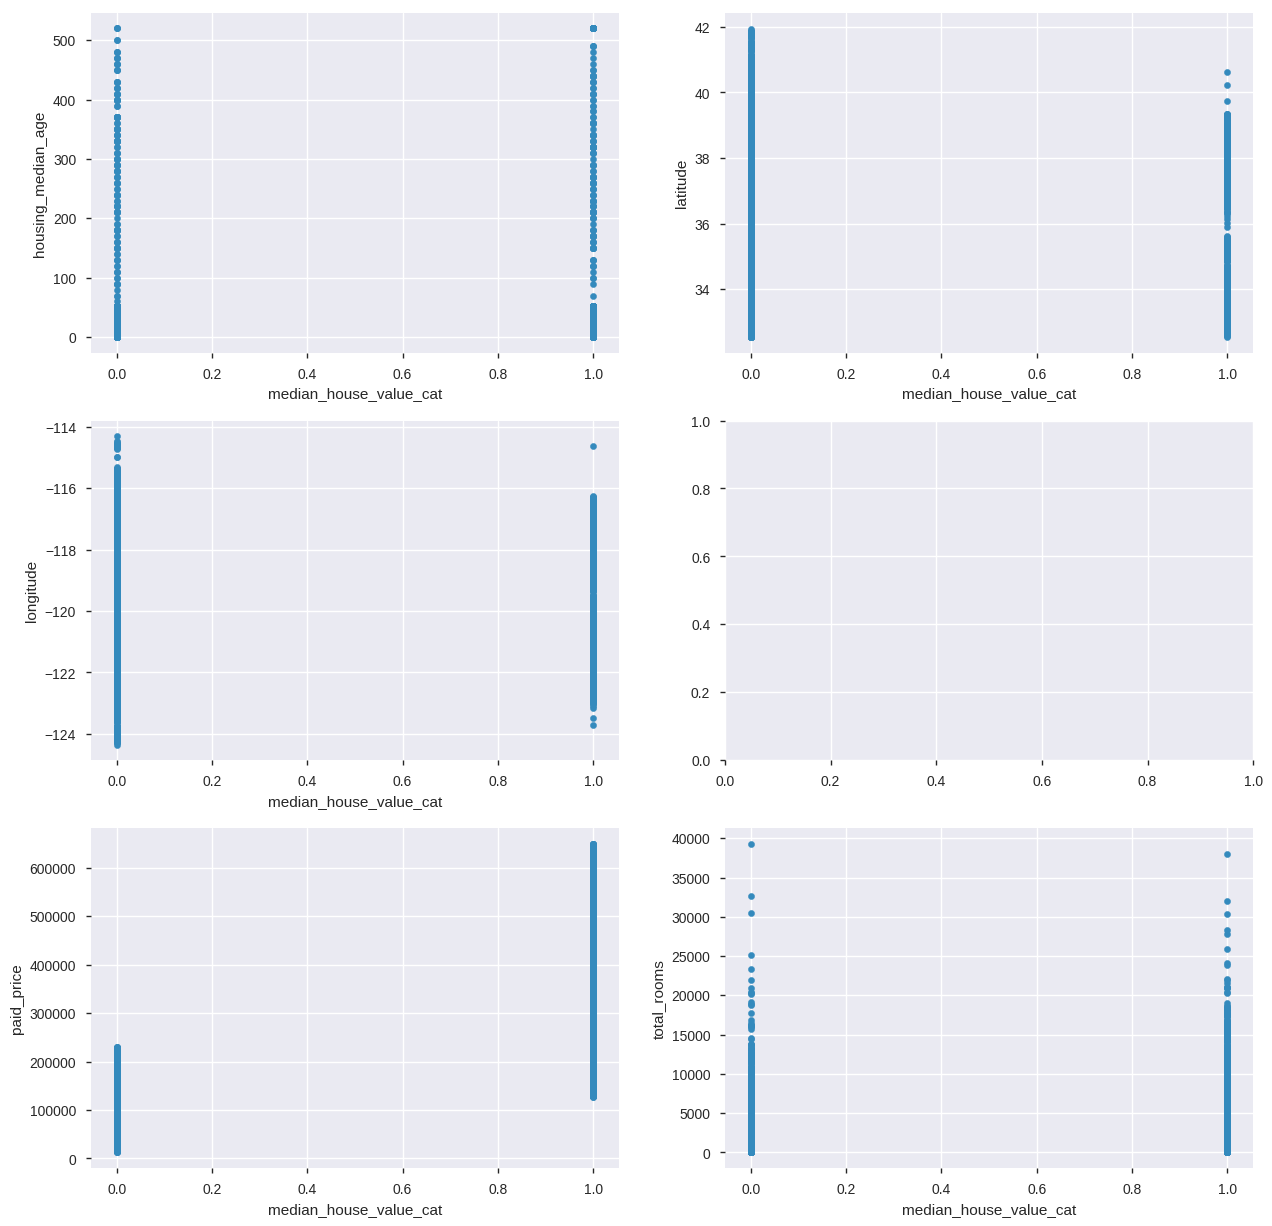

In [163]:
fig, axes = plt.subplots(3, 2, figsize = (15, 15))
full_df.plot.scatter(x = 'median_house_value_cat', y = 'housing_median_age', ax = axes[0, 0])
full_df.plot.scatter(x = 'median_house_value_cat', y = 'latitude', ax = axes[0, 1])
full_df.plot.scatter(x = 'median_house_value_cat', y = 'longitude', ax = axes[1, 0])
full_df.plot.scatter(x = 'median_house_value_cat', y = 'paid_price', ax = axes[2, 0])
full_df.plot.scatter(x = 'median_house_value_cat', y = 'total_rooms', ax = axes[2, 1])

# Select you features 

Select our ingredients: in this case it is simple as brokers will have only few fields in the app and the questions are fixed by the business. We will receive ONLY such data in production.

**TAKE HOME MESSAGE**: Be mindful of features, you may not have them in real world.
Is not what model you use, it is how you use it!

In [238]:
feature_columns = [
    'geohash',
    'ocean_proximity',
    'paid_price',
    'total_rooms',
]

categorical_features = ['geohash', 'ocean_proximity']
numerical_features = ['paid_price', 'total_rooms']

### Define get_data

In [239]:
def get_data(data_root):
    ch_p = pd.read_csv(train_data_root / "cal_housing_properties.csv")
    ch_op = pd.read_csv(train_data_root / "cal_housing_owner_property.csv")
    full_df = pd.merge(ch_p, ch_op, how = 'left', on = ['property_id'])
    full_df = full_df[~full_df['median_house_value_cat'].isnull()]
    full_df = full_df[full_df['total_rooms'] != 'unknown']
    full_df['total_rooms'] = pd.to_numeric(full_df['total_rooms'])
    full_df['paid_price'].fillna(full_df[~full_df['paid_price'].isnull()]['paid_price'].median(), inplace = True)
    full_df['geohash'] = full_df.apply(lambda row: geoencode(row['latitude'], row['longitude'], 2), axis = 1)
    full_df = full_df[[
        'geohash',
        'latitude',
        
        'ocean_proximity',
        'paid_price',
        'total_rooms',
        'median_house_value_cat'
    ]]
    return full_df[feature_columns], full_df['median_house_value_cat']

In [241]:
get_data(train_data_root)[0].head()

,geohash,ocean_proximity,paid_price,total_rooms
0,9q,<1H OCEAN,178922.0,2041.0
1,9q,NEAR BAY,414364.0,2296.0
2,9q,NEAR OCEAN,282695.0,1886.0
3,9q,NEAR BAY,348292.0,1674.0
4,9m,NEAR OCEAN,183652.0,1462.0


# Building the DSFlow

### Define analytical_steps

Analytical_steps refer to all transformations we want to apply to our data (including predicting with a model) which are subject to some sort of inference.

DSLib:
https://infra-nexus.service.gda.allianz/repository/documentation/python/azdslib/latest/_modules/azdslib.ml.html#azdslib.ml.CategoricalTransformer
SourceCode: https://gitlab.gda.allianz/AI-SHARING/DataScienceLibrary/blob/master/azdslib/ml/_categorical.py

**TAKE HOME MESSAGE**: The DSLib, allow us to quickly reuse predefined code functions while at the same time defining new ones if need be.

In [242]:
# analytical steps
analytical_steps = [
    # mark any categorical features as categorical, ensure the numeric columns contain only numbers,
    # and select columns to use as features.
    ('prepare', FuncTransformer(lambda df: df.pipe(
        prepare_data_frame,
        select=feature_columns,
        categorical_columns=categorical_features,
        numeric_columns={*feature_columns} - {*categorical_features},
    ))),
    # no need to specify the categorical columns, they are auto-detected based on the pandas dtype
    ('categorical', CategoricalTransformer(encoding_strategy='dummify')),
    # no need to specify the numeric columns, all non categories are automatically handled
    ('numeric', NumericTransformer(strategy="median")),
    # use the gradient boosting classifier
    ('classifier', GradientBoostingClassifier(n_estimators=200, max_depth=3))
]

### Initialize and train the DSFlow

Each application is an object of class DSFLow implementing specific get_data, analytical_steps, and api specifications.

By default cross validation is applied to analytical_steps.
Passing multiple algorithms or transformation sets result in the selection of the best one to achieve the desired target metric (default: AUC, but customizable)

In [243]:
# initialize the DSFlow
ds_flow = DSFlow(
    analytical_steps,
    get_fit_data = get_data
)
ds_flow.fit(get_data_kwargs=dict(data_root=train_data_root))

INFO:azdslib.ml._categorical:Aggregating levels with less than 5.0 % of occurrence to a maximum of 50 levels
INFO:azdslib.ml._categorical:Aggregate fit done;
INFO:azdslib.ml._categorical:Aggregating levels with less than 5.0 % of occurrence to a maximum of 50 levels
INFO:azdslib.ml._categorical:Aggregate fit done;
INFO:azdslib.ml._categorical:Aggregating levels with less than 5.0 % of occurrence to a maximum of 50 levels
INFO:azdslib.ml._categorical:Aggregate fit done;
INFO:azdslib.ml._categorical:Aggregating levels with less than 5.0 % of occurrence to a maximum of 50 levels
INFO:azdslib.ml._categorical:Aggregate fit done;


### Evaluate DSFlow

Text(0.5,1,'Variable Importance')

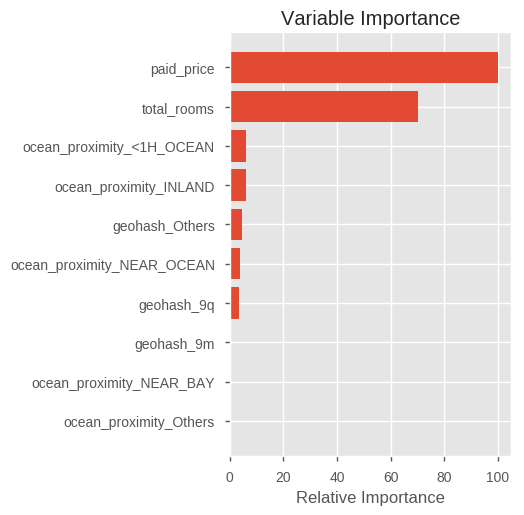

In [244]:
# feature importance
feature_importance = ds_flow.best_estimator.steps[3][1].feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, [ds_flow.best_estimator.final_columns_labels[i] for i in sorted_idx ])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')

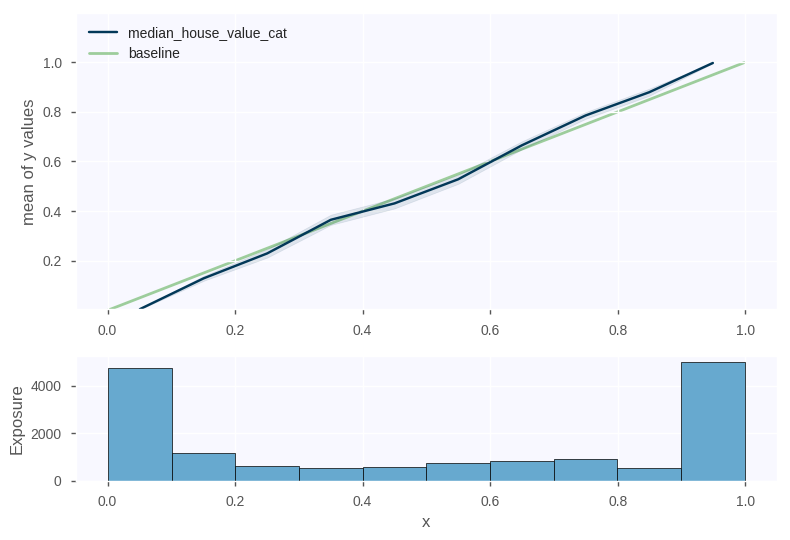

In [245]:
# Get test data and true target
testdata, true_label=get_data(test_data_root)
testdict = testdata.iloc[1:2,:].to_dict('r')

# compute predictions and show distribution
scores = ds_flow.predict(testdata) 

# scores = ds_flow.predict(get_data_kwargs=dict(data_root=test_data_root))
scores = scores[:, 1]

from azdslib.vis import plot_dependence
plot_dependence(scores, true_label, n_bins=10, set_baseline=True, pr_m=0.01, pr_M=0.99, grid=False, err_type='sem')

## Add postprocessing (Implement Business Strategy)

**TAKE HOME MESSAGE**: A model is not useful without a clear business strategy.

In [246]:
# example of postprocessing function working for single instance calls to APIs
def post_processing_function(data, pred_scores):

    # parameters
    fl = 1.5
    fN = 0.8
    off = 1.2
    C = 30000
    
    # extract the paid price
    paid_price = data.paid_price[0]
    # extract the probability of gaining value
    p = pred_scores[1][0]

    # if we have no info about the price we never make an offer, otherwise we do it based on a strategy
    if data.paid_price.isna()[0]:
        res = [{'API': {'res': -1, 'Advice': 'Do not buy! Unknown value of the House'}, 'LOG': {"KPI": 0,"request":data.to_dict(),"response": {'res': -1, 'Advice': 'Do not buy! Unknown value of the House'}}}]
    else: 
        # determine value of acquisition

        #
        #  your strategy
        #
        V = p*fl*paid_price + (1-p)*fN*paid_price - (off*paid_price + C)
        
        if V > 0:
            res = [{'API': {'res': V, 'Advice': 'Buy! Offer '+str(paid_price*off)+'€' }, 'LOG': {"KPI": V,"request":data.to_dict(),"response": {'res': V, 'Advice': 'Buy! Offer '+str(paid_price*off)+'€'}}}]
        else:
            res = [{'API': {'res': V, 'Advice': 'Do NOT Buy!' }, 'LOG': {"KPI": 0,"request":data.to_dict(),"response": {'res': V, 'Advice': 'Do NOT Buy!'}}}]

    return res

In [255]:
def pre_processing_function(data, numerical_features, categorical_features):
    df = pd.DataFrame(data)
    latitude = df['latitude']
    longitude = df['longitude']
    precision = 2
    __base32 = '0123456789bcdefghjkmnpqrstuvwxyz'
    lat_interval = (-90.0, 90.0)
    lon_interval = (-180.0, 180.0)
    geohash = []
    bits = [16, 8, 4, 2, 1]
    bit = 0
    ch = 0
    even = True
    while len(geohash) < precision:
        if even:
            mid = (lon_interval[0] + lon_interval[1]) / 2
            if longitude > mid:
                ch |= bits[bit]
                lon_interval = (mid, lon_interval[1])
            else:
                lon_interval = (lon_interval[0], mid)
        else:
            mid = (lat_interval[0] + lat_interval[1]) / 2
            if latitude > mid:
                ch |= bits[bit]
                lat_interval = (mid, lat_interval[1])
            else:
                lat_interval = (lat_interval[0], mid)
        even = not even
        if bit < 4:
            bit += 1
        else:
            geohash += __base32[ch]
            bit = 0
            ch = 0
    df['geohash'] = ''.join(geohash)
    df[categorical_features] = df[categorical_features].astype('category')
    for col in numerical_features:
        df[col] = pd.to_numeric(df[col])
    return df[categorical_features + numerical_features].copy()

In [256]:
# add desired postprocessing along with
ds_flow.pre_processing_function = pre_processing_function
ds_flow.pre_processing_params = dict(numerical_features = numerical_features, categorical_features = categorical_features)
ds_flow.post_processing_function = post_processing_function
ds_flow.pass_data_to_post_processing_function = True

In [257]:
ds_flow.api_predict(testdict)

KeyError: 'latitude'

# Evaluate final performance

In [ ]:
testdata['TT'] = true_label
hos = testdata.iloc[1000:1800,:].to_dict("r")
# estimate ROI
def evaluate_strategy(hos,ds_flow):
    
    pass

In [ ]:
evaluate_strategy(hos,ds_flow)

# Deployment

**TAKE HOME MESSAGE**: The DSLib, the ML-Server and the Dashboard allow us to quickly deploy a model in production and keep track of our KPIs.

### Check requirements.txt
Make sure that all required libraries are included in requirements.txt

In [ ]:
! cat requirements.txt

### Obtain absolute path to requirements.txt

In [ ]:
requirements_path = str(Path('requirements.txt').resolve())

### Create Gitlab personal token
You can create as many personal access tokens as you like from your GitLab profile.

1. Log in to [GitLab](https://gitlab.gda.allianz/).
2. In the upper-right corner, click your avatar and select Settings.
3. On the User Settings menu, select Access Tokens.
4. Choose a name and expiry date for the token.
5. Choose the desired scopes.
6. Click the Create personal access token button.
7. Save the personal access token somewhere safe. Once you leave or refresh the page, you won’t be able to access it again.
8. Initialize the variable bellow with your personal access token

In [ ]:
token = ''

In [ ]:
oe              = 'nooe'                       # Target oe
gitlab_email    = 'john.doe@allianz.com'       # Your gitlab email (<john.doe@allianz.de>).
deployment_repo = 'ml/ml-server-deploy'        # Target deployment repo. This may be different in every oe.
deployment_name = 'test_build'                 # The name you want to give to your build.


ds_flow.build(gitlab_email, token, deployment_repo, oe, deployment_name, requirements_path=requirements_path)

## Deploy ML-Server with Broccoli
Go to [broccoli](https://infra-cluster-broccoli.apps.dsp.allianz/) and search for the *ds-server* template. Once there create a new template or update an existing one.

**IMPORTANT** => Don't forget to set the following variables:

1. **ML Server Docker Image**: The name of the image created in the previous step
2. **Path to DSFlow**: should be */tmp/model.pkl*
3. **Dashboard Docker Image**: set it to _internal.docker.gda.allianz/ml-dashboard-develop_ to use demo dashboard.

### Query the model

Update ml_server_url with the URL where your ml-server is running (have a look in Broccoli).

In [ ]:
ml_server_url = 'https://nooe-dsflow-jupyter-ml.service.dsp.allianz:30309'

In [ ]:
# ignore warnings
warnings.filterwarnings('ignore')

# init client
client = MLServerClient(ml_server_url)

#### Send simple request

In [ ]:
payload = testdict
client.api_predict_proba(payload)

#### Send 200 requests. One per seccond

In [ ]:
max_requests = 200

for x in range(0, max_requests):
    
    client.api_predict_proba(payload)
    
    # whait for one seccond
    time.sleep(0.5)
    
print('Done!')